In [18]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

## animation stuff
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [3]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))

/home/qs6476/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [4]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    ax.coastlines()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)

    
def regionalmap(var, extent, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_extent(extent)
    ax.coastlines()
    gl = ax.gridlines()
    gl.top_labels = True
    gl.left_labels = True
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)

In [5]:
def regionaldata(data, extent):
    cell_mask = np.where((data.lat<extent[3]) & (data.lat>extent[2]) & (data.lon>extent[0]) & (data.lon<extent[1]))[0]
    data_regional = data.isel(cell=cell_mask)
    return data_regional

MSE = cpT + Lq + gz

In [6]:
def specific_humidity(relative_humidity, temperature_kelvin, pressure_hpa):
    """
    Calculate specific humidity using xarray DataArrays.

    Parameters:
        relative_humidity (xr.DataArray): Relative humidity (%) [0–100]
        temperature_kelvin (xr.DataArray): Air temperature (K)
        pressure_hpa (float or xr.DataArray): Air pressure (hPa), default is 1013.25 hPa

    Returns:
        xr.DataArray: Specific humidity (kg/kg)
    """
    # Convert temperature to Celsius
    temperature_celsius = temperature_kelvin - 273.15

    # Constants
    a = 17.67
    b = 243.5  # °C
    epsilon = 0.622  # ratio of molecular weight of water vapor to dry air

    # Saturation vapor pressure (es) in hPa
    es = 6.112 * np.exp((a * temperature_celsius) / (temperature_celsius + b))

    # Actual vapor pressure (e) in hPa
    e = (relative_humidity/100) * es

    # Specific humidity formula
    q = (epsilon * e) / (pressure_hpa - (1 - epsilon) * e)

    return q

def mse(temperature, sp_humidity, z):
    return temperature + 2.5e6*sp_humidity / 1004. + 9.8*z / 1004.

In [26]:
ds = ds.assign(hus = specific_humidity(ds.hur, ds.ta, ds.plev))
ds = ds.assign(mse = mse(ds.ta, ds.hus, ds.zg))

In [7]:
trop_AL = [-60, 0, 0, 15]
ds_tropAL = regionaldata(ds, trop_AL)


In [8]:
ds_tropAL = ds_tropAL.assign(hus = specific_humidity(ds_tropAL.hur, ds_tropAL.ta, ds_tropAL.plev))
ds_tropAL = ds_tropAL.assign(mse = mse(ds_tropAL.ta, ds_tropAL.hus, ds_tropAL.zg))



working on a small domain in the middle of the ocean, only a 4-day period

In [44]:
zoom_extent = [-33, -25, 4, 10]
ds_zoom = regionaldata(ds, zoom_extent)
ds_zoom = ds_zoom.sel(time=slice('2020-06-28', '2020-07-01'))

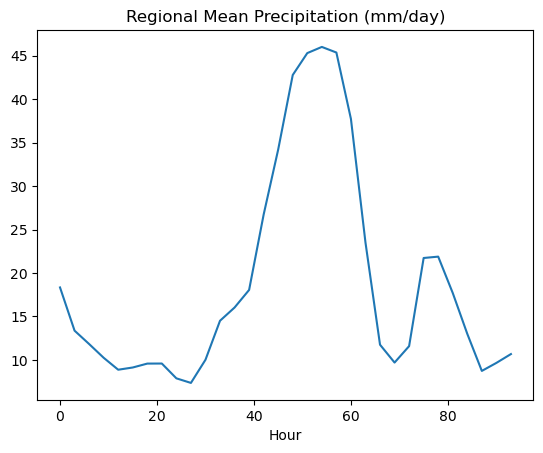

In [45]:
plt.plot(np.arange(32)*3, ds_zoom.pr.mean(dim='cell')*86400.)
plt.xlabel('Hour')
plt.title('Regional Mean Precipitation (mm/day)')
plt.show()

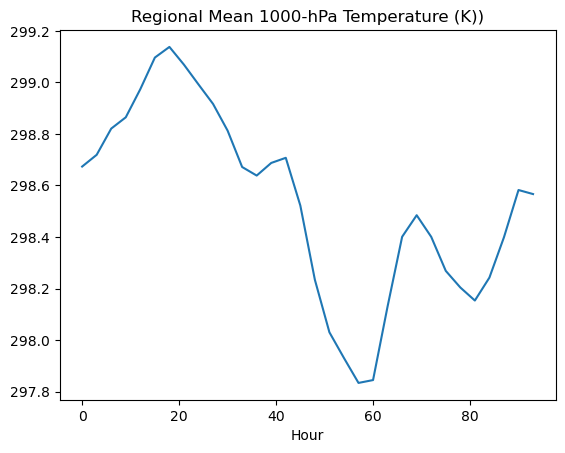

In [46]:
plt.plot(np.arange(32)*3, ds_zoom.ta.sel(plev=1000).mean(dim='cell'))
plt.xlabel('Hour')
plt.title('Regional Mean 1000-hPa Temperature (K))')
plt.show()

In [47]:
print(ds_zoom.mse.sel(plev=slice(100, 1000)).min().values)
print(ds_zoom.mse.sel(plev=slice(100, 1000)).max().values)

324.69043
366.95386


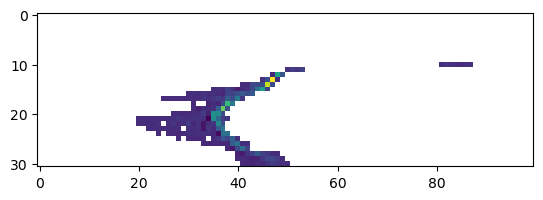

In [48]:
# bin MSE from lb to ub
lb = 320
ub = 370
bin_width = 0.5
mse_bins = np.arange(lb, ub+bin_width, bin_width)

isentropic_massflux = ds_zoom['wap'].groupby_bins(ds_zoom['mse'],mse_bins).sum(dim='cell')
# assuming that there should not be exact 0 massflux
# then all 0 should be from non-existence of the corresponding MSE
isentropic_massflux = isentropic_massflux.where(isentropic_massflux!=0, np.nan) / (-9.8)
plt.imshow(isentropic_massflux[0, :, :])

In [32]:
ds_zoom

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 32, cell: 50638, plev: 31, pfull: 79)
Coordinates:
  * pfull    (pfull) float32 316B 4.514 8.301 12.45 16.74 ... 989.5 994.3 998.3
  * plev     (plev) float32 124B 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 256B 2020-06-28 00:00:00 ... 2020-07-01 21:00:00
    crs      int64 8B 0
  * cell     (cell) int64 405kB 0 1 2 3 4 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 405kB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
    lon      (cell) float64 405kB 45.0 45.35 44.65 45.0 ... -44.65 -45.35 -45.0
Data variables: (12/40)
    clivi    (time, cell) float32 6MB dask.array<chunksize=(1, 50638), meta=np.ndarray>
    clt      (time, cell) float32 6MB dask.array<chunksize=(1, 50638), meta=np.ndarray>
    clwvi    (time, cell) float32 6MB dask.array<chunksize=(1, 50638), meta=np.ndarray>
    hflsd    (time, cell) float32 6MB dask.array<chunksize=(1, 50638), meta=np.ndarray>
    hfssd    (time, cell) float32 6MB dask.array<chunksize=(1, 50638), meta=np.ndarray>
    hur      (time, plev, cell) float32 201MB dask.array<chunksize=(1, 8, 50638), meta=np.ndarray>
    ...       ...
    vas      (time, cell) float32 6MB dask.array<chunksize=(1, 50638), meta=np.ndarray>
    wa       (time, plev, cell) float32 201MB dask.array<chunksize=(1, 8, 50638), meta=np.ndarray>
    wap      (time, plev, cell) float32 201MB dask.array<chunksize=(1, 8, 50638), meta=np.ndarray>
    zg       (time, plev, cell) float32 201MB dask.array<chunksize=(1, 8, 50638), meta=np.ndarray>
    hus      (time, plev, cell) float32 201MB dask.array<chunksize=(1, 8, 50638), meta=np.ndarray>
    mse      (time, plev, cell) float32 201MB dask.array<chunksize=(1, 8, 50638), meta=np.ndarray>

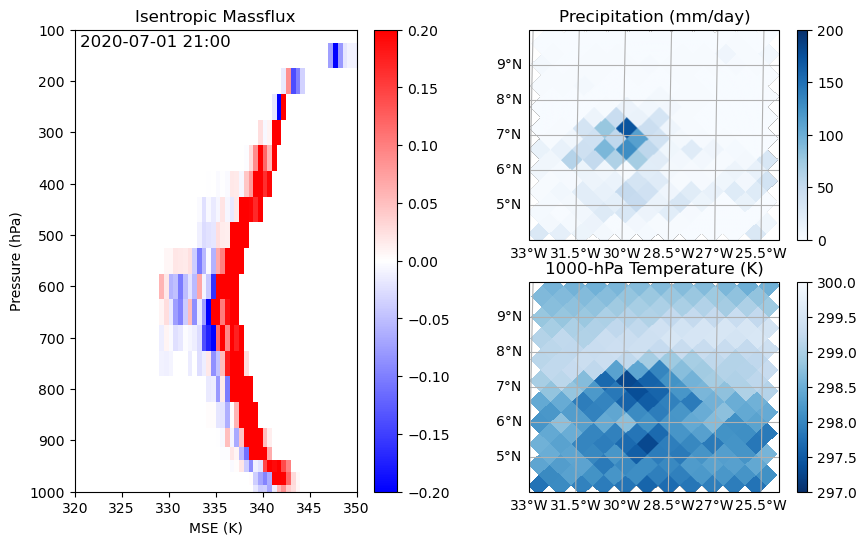

In [53]:
%matplotlib inline
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson(central_longitude=0))
ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson(central_longitude=0))
#ax0 = fig.add_subplot(1, 2, 1)
#ax1 = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=0))
#ax2 = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=0))
ax = [ax0, ax1, ax2]
mesh = ax[0].pcolormesh(mse_bins[:-1]+0.5*bin_width, ds_zoom.plev.values, isentropic_massflux[0, :, :],
                        cmap='bwr', vmin=-0.2, vmax=0.2)
title = ax[0].set_title(f'Isentropic Massflux')
ax[0].set_xlabel('MSE (K)')
ax[0].set_ylabel('Pressure (hPa)')
ax[0].set_ylim(1000, 100)
ax[0].set_xlim(320, 350)
fig.colorbar(mesh, ax=ax[0])

time_text = ax[0].text(
    0.02, 0.99, "", transform=ax[0].transAxes,
    fontsize=12, 
    verticalalignment='top'
)

def regionalmap_ax(var, extent, ax, **kwargs):
    ax.clear()
    ax.set_extent(extent)
    ax.coastlines()
    
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    return hpshow

pr_plot = regionalmap_ax(ds_zoom.pr.isel(time=0)*86400., zoom_extent, ax=ax[1], cmap='Blues', vmin=0, vmax=200)
pr_cbar = fig.colorbar(pr_plot, ax=ax[1], orientation='vertical')
ax[1].set_title('Precipitation (mm/day)')

tas_plot = regionalmap_ax(ds_zoom.ta.sel(plev=1000).isel(time=0), zoom_extent, ax=ax[2], cmap='Blues_r', vmin=297, vmax=300)
tas_cbar = fig.colorbar(tas_plot, ax=ax[2], orientation='vertical')
ax[2].set_title('1000-hPa Temperature (K)')

# Animation update function
def update(frame):
    Z = isentropic_massflux[frame, :, :].values
    mesh.set_array(Z.ravel())  # flatten Z and update mesh
    
    ax[1].cla()
    pr_plot = regionalmap_ax(ds_zoom.pr.isel(time=frame)*86400., zoom_extent, ax=ax[1], cmap='Blues', vmin=0, vmax=200)
    ax[1].set_title('Precipitation (mm/day)')
    
    ax[2].cla()
    tas_plot = regionalmap_ax(ds_zoom.ta.sel(plev=1000).isel(time=frame), zoom_extent, ax=ax[2], cmap='Blues_r', vmin=297, vmax=300)
    ax[2].set_title('1000-hPa Temperature (K)')
    
    current_time = ds_zoom.time.values[frame]
    time_text.set_text(f"{str(current_time)[:16]}")
    
    return [mesh]

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=32, interval=50, blit=True
)

# Display inline
HTML(ani.to_jshtml())

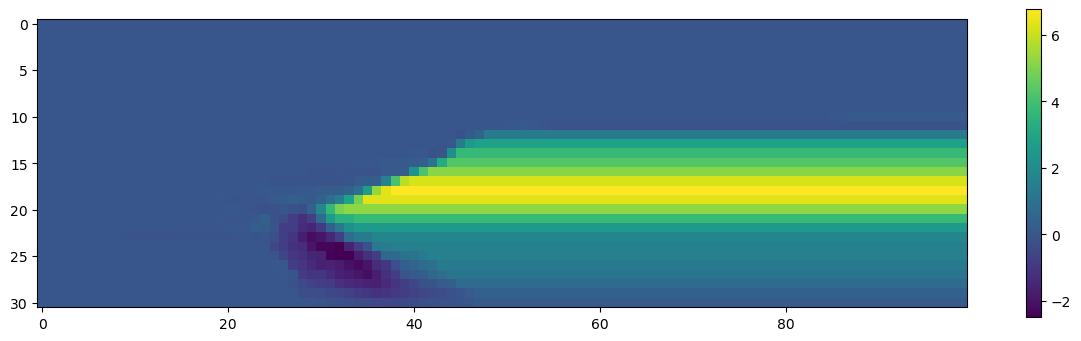

In [63]:
plt.figure(figsize=(15, 4))
plt.imshow(isentropic_massflux[20, :, :].cumsum(dim="mse_bins"))
plt.colorbar()

In [25]:
ani.save("tropAL_animation.mp4", writer="ffmpeg", fps=5)

composite mse profiles

441.634
454.70947
336.78836
371.79385
279.06528
346.5469
193.93758
215.78076
344.98593
261.48737
273.98044
380.769
480.40524
442.2075
366.77646
517.74677
358.47726
610.2674
470.86673
607.0956
560.1977
363.58368
323.3547
422.0655
392.98712
516.7654
446.77963
355.46265
410.93774
558.58435
413.37518
371.94418


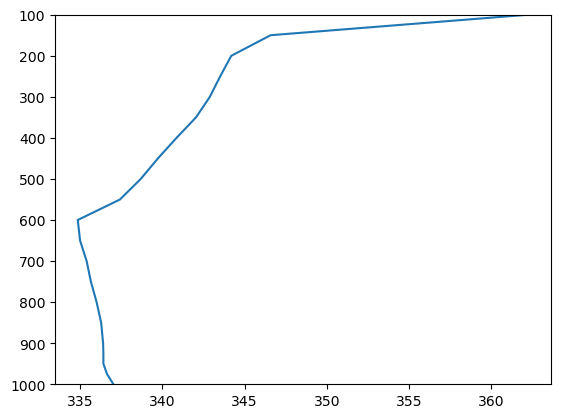

In [15]:
mse_profile = []
for i in range(32):
    cell_max_pr = ds_zoom.pr.isel(time=i).idxmax(dim='cell')
    print(ds_zoom.pr.isel(time=i).sel(cell=cell_max_pr).values*86400.)
    if ds_zoom.pr.isel(time=i).sel(cell=cell_max_pr).values*86400. > 0.:
        mse_profile.append(ds_zoom.mse.isel(time=i).sel(cell=cell_max_pr)[10:].values)
    #plt.plot( ds_zoom.mse.isel(time=i).sel(cell=cell_max_pr)[10:], ds_zoom.plev[10:])
#plt.ylim(1000, 100)
#plt.show()
mse_profiles = np.array(mse_profile)
mean_mse_profile = mse_profiles.mean(axis=0)
std_mse_profile = mse_profiles.std(axis=0)

plt.plot( mean_mse_profile, ds_zoom.plev[10:])
plt.ylim(1000, 100)
plt.show()

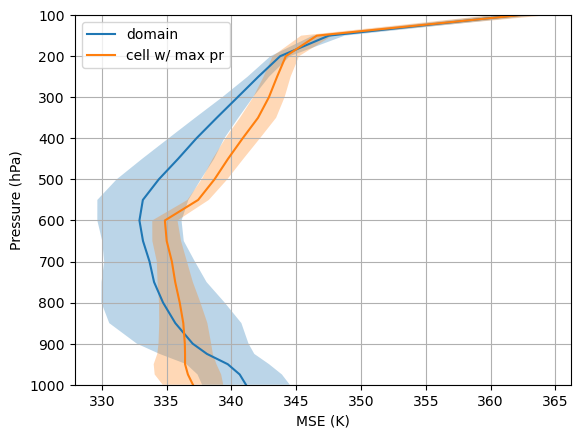

In [16]:
plt.plot( ds_zoom.mse.mean(dim=('cell', 'time'))[10:], ds_zoom.plev[10:], label='domain')
mean_env_mse = ds_zoom.mse.mean(dim=('cell', 'time'))[10:]
std_env_mse = ds_zoom.mse.std(dim=('cell', 'time'))[10:]
plt.fill_betweenx(ds_zoom.plev[10:], mean_env_mse-std_env_mse, mean_env_mse+std_env_mse, alpha=0.3)
plt.plot( mean_mse_profile, ds_zoom.plev[10:], label='cell w/ max pr')
plt.fill_betweenx(ds_zoom.plev[10:], mean_mse_profile-std_mse_profile, mean_mse_profile+std_mse_profile, alpha=0.3)
plt.ylim(1000, 100)
plt.legend()
plt.grid()
plt.xlabel('MSE (K)')
plt.ylabel('Pressure (hPa)')
plt.show()

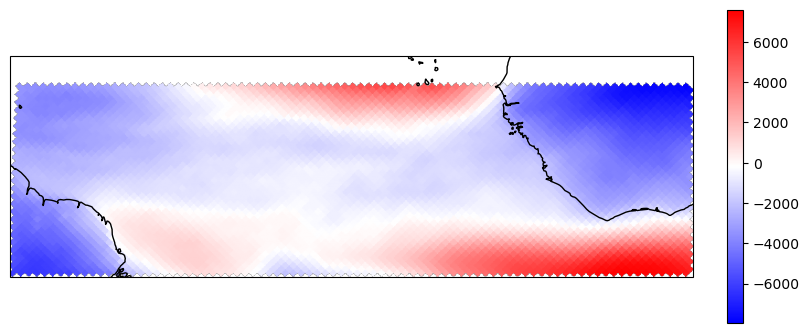

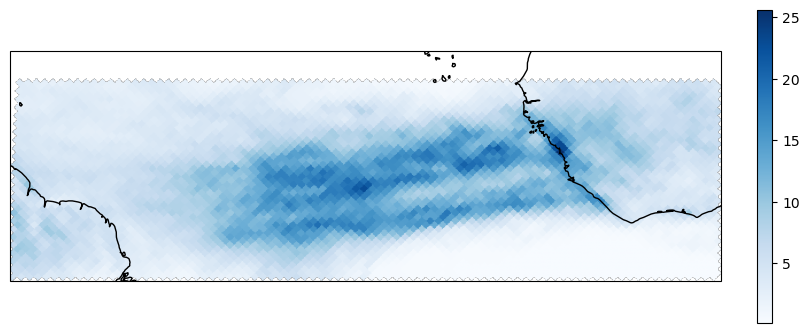

In [50]:
mse_JJA_mean = ds_tropAL.mse.sel(time=slice('2020-06-01', '2020-08-31')).mean(dim='time')
P_JJA_mean = ds_tropAL.pr.sel(time=slice('2020-06-01', '2020-08-31')).mean(dim='time')
regionalmap(mse_JJA_mean.sel(plev=500) - mse_JJA_mean.sel(plev=850), trop_AL, cmap='bwr')
regionalmap(P_JJA_mean*86400., trop_AL, cmap='Blues')